In [ ]:
# Author:   Chris Graziul
# Created: 9/23/21
#
# Note: Code here used to create...
#   code/ds093_decode.py
#
# Uses:      1. Output batches of files for decoding
#            2. Developing code to use DeepSpeech 0.9.3 speech recognizer 
#            3. Assessing DeepSpeech 0.9.3 accuracy using manually transcribed BPC data

In [31]:
from deepspeech import Model
from datetime import datetime
from multiprocessing import Pool, current_process, Queue
from jiwer import wer
import pandas as pd
import numpy as np
import pydub
import pickle
import os 

os.chdir('/project/graziul/')

today = datetime.today().strftime('%Y-%m-%d')
today = today.replace('-','_')
today

'2021_10_01'

# Some helper functions

In [38]:
def get_filenames(df):
    try:
        df['file'] = df['file'].str.split('(\d*-\d*-\d*)',expand=True)[1]+'.mp3'
        return df
    except:
        print('Error finding "file" variable in DataFrame')

def get_date(df, base_path='.'):
    # Load file directory structure
    file_date_dir_dict = {}
    for (dirpath, dirnames, filenames) in os.walk(base_path):
        for filename in filenames:
            if filename.endswith('.mp3'): 
                file_date_dir_dict[filename] = dirpath.split('/')[-1]
    df['date'] = df['file'].map(file_date_dir_dict)
    return df

# def dt_to_seconds(df):
#     try:
#         for i in ['start_dt', 'end_dt']:
#             var_name = i.split('_')[0]
#             df[var_name] = (df[i]-np.datetime64('1900-01-01T00:00:00.000000000')).dt.total_seconds()
#         return df
#     except:
#         print('Error processing "start_dt" and/or "end_dt" variables in DataFrame')
        
def get_asr_vars(df):
    df = get_filenames(df)
    df = get_date(df)
    #df = dt_to_seconds(df) 
    return df[['zone','date','time','file','start','end','transcriber','transcription']].copy()

def get_vad_vars(df):
    df = get_filenames(df)
    df = get_date(df) # Dates from file don't always line up with date directories
    #df = dt_to_seconds(df) 
    df['start'] = (1000*df['start']).astype(int)
    df['end'] = (1000*df['end']).astype(int)
    return df[['zone','date','time','file','start','end','transcriber']].copy()

def remove_irrelevant(x):
    x = str(x)
    x = x.replace("\[Uncertain\]","")
    x = x.replace("INAUDIBLE","")    
    x = x.replace("<X>","")
    x = x.replace("-"," ")
    x = ' '.join(x.split())
    x = ''.join([i for i in x if i.isalnum() or i==' '])
    x = x.strip()
    x = x.upper()
    return x

In [12]:
# Function to output batches of files for decoding 
def get_metadata_forASR(t_file, num_batches=8, by_utt=False):
    # Load the transcript file, parsing date variables
    df = pd.read_csv(t_file)
    # Process transcript data for ASR variables
    df = get_asr_vars(df)
    # Include (start, end) for utterances if by_utt = True
    if by_utt:
        # Build dict of form {(zone, date, filename):[(start,end)]}
        file_utt_dict = {g_name:group[['start','end']].to_records(index=False).tolist() for g_name, group in df[['zone','date','file','start','end']].drop_duplicates().groupby(['zone','date','file'])}
        # NOTE: length of each element = 2
        file_metadata_forASR = list(file_utt_dict.items())
    else:
        # NOTE: length of each element = 3  
        file_metadata_forASR = df[['zone','date','file']].drop_duplicates().to_records(index=False).tolist()
    # Create batches of metadata
    batches = np.array_split(file_metadata_forASR, num_batches)
    n = 1
    for batch in batches:
        # Save batches of metadata to file using different names for by utterance vs. whole file
        if by_utt:
            batch_file = 'features/asr/utt_batch'+today+'_'+str(n)+'.pk'
            print(batch_file)
        else:
            batch_file = 'features/asr/batch'+today+'_'+str(n)+'.pk'
            print(batch_file)
        pickle.dump(batch,open(batch_file,'wb'))
        n += 1

In [13]:
# Testing get_metadata_forASR
get_metadata_forASR('transcripts/transcripts2021_09_30.csv')
get_metadata_forASR('transcripts/transcripts2021_09_30.csv',by_utt=True)

features/asr/batch2021_09_30_1.pk
features/asr/batch2021_09_30_2.pk
features/asr/batch2021_09_30_3.pk
features/asr/batch2021_09_30_4.pk
features/asr/batch2021_09_30_5.pk
features/asr/batch2021_09_30_6.pk
features/asr/batch2021_09_30_7.pk
features/asr/batch2021_09_30_8.pk
features/asr/utt_batch2021_09_30_1.pk
features/asr/utt_batch2021_09_30_2.pk
features/asr/utt_batch2021_09_30_3.pk
features/asr/utt_batch2021_09_30_4.pk
features/asr/utt_batch2021_09_30_5.pk
features/asr/utt_batch2021_09_30_6.pk
features/asr/utt_batch2021_09_30_7.pk
features/asr/utt_batch2021_09_30_8.pk


/home/graziul/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


# Set DeepSpeech 0.9.3 args

In [ ]:
model_path = '/project/graziul/code/deepspeech/deepspeech-0.9.3-models.pbmm'
scorer_path = '/project/graziul/code/deepspeech/deepspeech-0.9.3-models.scorer'
beam = 250
alpha = 0.3
beta = 0.05

# 1. Output batches of files for decoding

In [ ]:
# Load transcript data, extract set of .mp3 files for DeepSpeech to decode
df_transcripts = pd.read_csv('transcripts/transcripts2021_09_30.csv')
df_transcripts = get_asr_vars(df_transcripts)
files_to_transcribe = df_transcripts[['zone','date','file']].drop_duplicates().to_records(index=False).tolist()
# Total files with transcriptions
len(files_to_transcribe)

In [ ]:
# Problem files (likely mispellings of some kind)
[i for i in files_to_transcribe if i[1] is np.nan]

In [ ]:
# Save all files for transcription in 4 batches
num_files = len(files_to_transcribeT)
batches = np.array_split(files_to_transcribeT,4)
n = 1
for batch in batches:
    pickle.dump(batch,open('batch'+str(n)+'.pk','wb'))
    n += 1

In [ ]:
batch

In [ ]:
# Load voice activity data, extract set of .mp3 files for DeepSpeech to decode
# NOTE: Voice activity data is a subset of transcription data where transcripts are matched according to
#           overlap in windows of voice activity identified by two transcribers
df_va = pd.read_csv('transcripts/df_va2021_09_17.csv', index_col=0)
df_va = df_va.rename(columns={'filename':'file',
                             'start_voice':'start',
                             'end_voice':'end'})
files_to_transcribeVA = df_va[['zone','date','file']].drop_duplicates().to_records(index=False).tolist()
# Subset of total files where two RA transcribers agreed on voice activity windows at least once
len(files_to_transcribeVA)

In [ ]:
# This should be greater than zero 
len([i for i in files_to_transcribeT if i not in files_to_transcribeVA])

In [ ]:
# This should be zero
len([i for i in files_to_transcribeVA if i not in files_to_transcribeT])

In [ ]:
file_info = files_to_transcribeVA[2]
file_info

# Test file level DeepSpeech 0.9.3 decode

In [ ]:
ds = Model(model_path) 

In [ ]:
ds.enableExternalScorer(scorer_path)
ds.setBeamWidth(beam)
ds.setScorerAlphaBeta(alpha,beta)

In [ ]:
# Check that path to file is correct
file_path = '/project/graziul/data/'+'/'.join(file_info)
file_path

In [ ]:
# Get audio data, set sample rate to 16khz (expected by DeepSpeech decoder)
audio = pydub.AudioSegment.from_mp3(file_path)
audio = audio.set_frame_rate(16000)
type(audio)

In [ ]:
# Convert audio data to np.array (expected by DeepSpeech decoder)
audio = audio.get_array_of_samples()
data = np.frombuffer(audio, np.int16)
type(data)

In [ ]:
# Confirm ~30 min of audio
len(data)/16000/60

In [ ]:
# This returns 5 possible transcripts
%%time
text = ds.sttWithMetadata(data, num_results=5)

In [ ]:
len(text.transcripts)

In [ ]:
t1 = text.transcripts[0]

In [ ]:
''.join([i.text for i in t1.tokens])

In [ ]:
t1_dict = {i:text.transcripts[i].confidence for i in range(0,5)}

In [ ]:
# Here are confidence values for each transcript (higher is better)
t1_dict

In [ ]:
# This returns the transcript with the highest confidence value
%%time
text2 = ds.stt(data)

In [ ]:
text2

## Try to parallelize DeepSpeech decoding (not working)

In [ ]:
def ds_decode_audio(zone, date, file):
    file_path = '/project/graziul/data/'+'/'.join([zone,date,file])
    audio = pydub.AudioSegment.from_mp3(file_path)
    audio = audio.set_frame_rate(16000)  
    audio = audio.get_array_of_samples()
    data = np.frombuffer(audio, np.int16)
    
    ds = Model(model_path) 
    ds.enableExternalScorer(scorer_path)
    ds.setBeamWidth(beam)
    ds.setScorerAlphaBeta(alpha,beta)    
    text = ds.stt(data)
    return text

In [ ]:
def ds_decode_files(file_info_list):
    info = file_info_list[0:4]
    p = Pool(processes = 4)
    output = p.starmap(ds_decode_audio, info)
    p.close()
    return output
    #nonsilent_slices_dict = {k:v for i in output for k,v in i.items()}

In [ ]:
output = ds_decode_files(files_to_transcribeVA[1:])

In [ ]:
output

In [ ]:
del ds

In [ ]:
import tensorflow as tf

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

In [ ]:
NUM_GPUS = 4
PROC_PER_GPU = 1    

queue = Queue()

def ds_decode_audio(file_info):
    zone, date, file = file_info
    gpu_id = queue.get()
    try:
        # run processing on GPU <gpu_id>
        ident = current_process().ident
        print('{}: starting process on GPU {}\n'.format(ident, gpu_id))
        # ... process filename
        file_path = '/project/graziul/data/'+'/'.join([zone,date,file])
        audio = pydub.AudioSegment.from_mp3(file_path)
        audio = audio.set_frame_rate(16000)  
        audio = audio.get_array_of_samples()
        data = np.frombuffer(audio, np.int16)

        ds = Model(model_path) 
        ds.enableExternalScorer(scorer_path)
        ds.setBeamWidth(beam)
        ds.setScorerAlphaBeta(alpha,beta)    
        text = ds.stt(data)
        print('{}: finished'.format(ident))
    finally:
        queue.put(gpu_id)

# initialize the queue with the GPU ids
for gpu_ids in range(NUM_GPUS):
    for _ in range(PROC_PER_GPU):
        queue.put(gpu_ids)

pool = Pool(processes=PROC_PER_GPU * NUM_GPUS)
files = files_to_transcribeVA[1:]
for _ in pool.imap_unordered(ds_decode_audio, files):
    pass
pool.close()
pool.join()

## Fall back to iterative file transcription using one GPU


In [ ]:
ds = Model(model_path) 
ds.enableExternalScorer(scorer_path)
ds.setBeamWidth(beam)
ds.setScorerAlphaBeta(alpha,beta)    

In [ ]:
# Function to decode one mp3 file, returning highest confidence transcript
def ds_decode_audio(file_path):
    audio = pydub.AudioSegment.from_mp3(file_path)
    audio = audio.set_frame_rate(16000)  
    audio = audio.get_array_of_samples()
    data = np.frombuffer(audio, np.int16)
    text = ds.stt(data)
    return text

In [ ]:
# Test iterative decoding strategy
ds_transcript_dict = {}
ds_transcript_dict['meta'] = {'model':model_path,
        'scorer':scorer_path,
        'beam_width':beam,
        'alpha':alpha,
        'beta':beta,
        'audio_files':files_to_transcribeVA}

error_files = []
for file_info in files_to_transcribeVA:
    try:
        zone, date, file = file_info
        file = '/'.join([zone,date,file])
        file_path = '/project/graziul/data/'+file
        text = ds_decode_audio(file_path)
        ds_transcript_dict[file] = text
    except:
        error_files.append(file_info)
        continue

ds_transcript_dict['error_file_info'] = error_files

pickle.dump(ds_transcript_dict,open('/project/graziul/features/asr/ds093_transcript_dictTest_'+today+'.pk','wb'))

In [ ]:
# Wrapper function for above (deprecated, included for historical reasons)
def decode_files_sequentially(list_of_files):
    error = []
    ds_transcript_dict = {}
    for file_info in list_of_files:
        try:
            zone, date, file = file_info
            file = '/'.join([zone,date,file])
            file_path = '/project/graziul/data/'+file
            text = ds_decode_audio(file_path)
            ds_transcript_dict[file] = text
        except:
            error.append(file_info)
    return ds_transcript_dict, error

In [ ]:
# Now decode audio in transcribed files but not ones that are part of the voice activity data set
files_to_process = [i for i in files_to_transcribeT if i not in files_to_transcribeVA]
ds_transcript_dict2, errorT = decode_files_sequentially(files_to_process)
ds_transcript_dictT = {**ds_transcript_dict, **ds_transcript_dict2}
pickle.dump(ds_transcript_dictT,open('/project/graziul/data/ds_transcript_dictT.pk','w'))
pickle.dump(errorT,open('/project/graziul/data/error_filesT.pk','w'))

# Test utterance level DeepSpeech 0.9.3 decode

In [ ]:
df_transcripts = pd.read_csv('transcripts/transcripts2021_09_30.csv')
df_transcripts = get_vad_vars(df_transcripts)
df_transcripts.head()

In [ ]:
utterances_to_transcribe = df_transcripts[['zone','date','file','start','end']].drop_duplicates().to_records(index=False).tolist()
# Total files with transcriptions
len(utterances_to_transcribe)

In [ ]:
# Group voice activity slices by file in a dict
file_utt_dict = {g_name:group[['start','end']].to_records(index=False).tolist() for g_name, group in df_transcripts[['zone','date','file','start','end']].drop_duplicates().groupby(['zone','date','file'])}
len(file_utt_dict)

In [ ]:
file_utt_dict_aslist = list(file_utt_dict.items())

In [ ]:
file_utt_dict_aslist[0]

In [ ]:
# Save all files for transcription in 4 batches
num_files = len(file_utt_dict_aslist)
batches = np.array_split(file_utt_dict_aslist,8)
n = 1
for batch in batches:
    print(len(batch))
    pickle.dump(batch,open('features/asr/utt_batch'+str(n)+'.pk','wb'))
    n += 1

In [ ]:
batch[0][1]

In [ ]:
len(batch[0])

# Assess DeepSpeech (0.9.3) accuracy

In [ ]:
# Average inter-transcriber WER (use pre-transcribed files, create scatterplot?)

In [127]:
df_transcripts = pd.read_csv('transcripts/transcripts2021_09_30.csv')
df_transcripts = get_asr_vars(df_transcripts)
#df_transcripts['start'] = (1000*df_transcripts['start']).astype(int)
#df_transcripts['end'] = (1000*df_transcripts['end']).astype(int)
df_transcripts.head()

,zone,date,time,file,start,end,transcriber,transcription
0,Zone1,2018_08_12,932,201808120932-28710-27730.mp3,141.252,151.279,huthealex,RADIOSHOP TESTING ONE TWO THREE FOUR FIVE FIVE...
1,Zone1,2018_08_12,932,201808120932-28710-27730.mp3,158.109,159.417,huthealex,ONE TWO ONE TWO
2,Zone1,2018_08_12,932,201808120932-28710-27730.mp3,168.327,169.235,huthealex,UNIT COMING IN
3,Zone1,2018_08_12,932,201808120932-28710-27730.mp3,175.330,177.437,huthealex,ZONE ONE IS ON CITY [WIDE] FIVE
4,Zone1,2018_08_12,932,201808120932-28710-27730.mp3,184.003,189.017,huthealex,OKAY THANKS UH THIS IS THE RADIO SHOP TESTING ...


In [122]:
import glob
files = glob.glob('features/asr/ds093_transcript_dict*utt_2021_10_01.pk')
files

['features/asr/ds093_transcript_dict4utt_2021_10_01.pk',
 'features/asr/ds093_transcript_dict3utt_2021_10_01.pk',
 'features/asr/ds093_transcript_dict2utt_2021_10_01.pk',
 'features/asr/ds093_transcript_dict1utt_2021_10_01.pk',
 'features/asr/ds093_transcript_dict8utt_2021_10_01.pk',
 'features/asr/ds093_transcript_dict7utt_2021_10_01.pk',
 'features/asr/ds093_transcript_dict6utt_2021_10_01.pk',
 'features/asr/ds093_transcript_dict5utt_2021_10_01.pk']

In [124]:
def get_ds_transcripts_dict(files):
    ds_transcripts_dict = {}
    for file in files:
        transcripts_dict = pickle.load(open(file,'rb'))
        temp_dict = {k:transcripts_dict[k] for k in transcripts_dict if k not in ['meta','error_file_info']}
        for k in temp_dict:
            ds_transcripts_dict[k] = temp_dict[k]
    return ds_transcripts_dict
ds_transcripts_dict = get_ds_transcripts_dict(files)
len(ds_transcripts_dict.keys())

219

In [128]:
def process_ds_transcripts(ds_transcripts_dict, var_name='DStranscription'):
    df = pd.DataFrame(columns=['file','start','end',var_name])
    for file in ds_transcripts_dict:
        df_temp = pd.DataFrame.from_dict(ds_transcripts_dict[file], orient='index').reset_index()
        df_temp.columns.values[0:2] = ['timing', var_name]
        df_temp[var_name] = df_temp[var_name].str.upper()
        df_temp['start'], df_temp['end'] = zip(*df_temp.timing)
        df_temp['file'] = file
        df = df.append(df_temp[['file','start','end',var_name]])
    return df
df_ds_transcripts = process_ds_transcripts(ds_transcripts_dict)
len(df_ds_transcripts)

51428

In [129]:
df_ds_transcripts.head()

,file,start,end,DStranscription
0,201808121401-396777-27730.mp3,108.738,109.859,ARICIE
1,201808121401-396777-27730.mp3,118.139,120.345,ON SUSIE FOR FIFTEEN FIFTY
2,201808121401-396777-27730.mp3,121.224,121.935,I
3,201808121401-396777-27730.mp3,124.774,138.556,BUT WELL I PLEASE FREE COUPON IN NORTH ELATE T...
4,201808121401-396777-27730.mp3,139.677,143.067,THAT'S FOR I COME FROM OR AS AN APE


In [139]:
df_acc = df_transcripts.merge(df_ds_transcripts, on=['file','start','end'])
df_acc['length'] = df_acc['end'] - df_acc['start']
len(df_acc), len(df_ds_transcripts), len(df_transcripts)

(51474, 51428, 51474)

In [140]:
# Missing transcriptions (DeepSpeech produced nothing)
missing = df_acc[df_acc['DStranscription']=='']
len(missing), len(missing)/len(df_transcripts) 

(17165, 0.3334693243190737)

<AxesSubplot:>

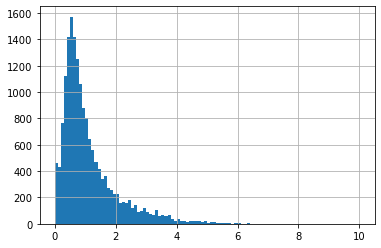

In [142]:
missing['length'].hist(bins=100,range=(0,10))

In [143]:
missing['length'].describe()

count    17165.000000
mean         1.109907
std          0.932806
min          0.009430
25%          0.506000
50%          0.812000
75%          1.401000
max         12.311000
Name: length, dtype: float64

In [ ]:
def get_wer(df_transcripts, ds_transcripts_dict, file_info):
    file = file_info[-1]
    ds_text = ds_transcripts_dict[file_info]
    ds_text = remove_irrelevant(ds_text)
    df_relevant_transcripts = df_transcripts[df_transcripts['file']==file]
    df_relevant_transcripts = df_relevant_transcripts.sort_values('start')
    transcribers = df_relevant_transcripts['transcriber'].unique().tolist()
    wer_list = []
    if len(transcribers) > 1:
        n = 1
        while n < 3:
            for transcriber in transcribers:
                transcription = df_relevant_transcripts.loc[df_relevant_transcripts['transcriber']==transcriber,'transcription']
                human_text = ' '.join(transcription)
                human_text = remove_irrelevant(human_text)
                wer_list.append(wer(human_text, ds_text))
                n += 1    
    return file, wer_list[0], wer_list[1]

In [145]:
#get_wer(df_transcripts, ds_transcripts_dict, file_info)

KeyError: ('Zone4', '2018_08_10', '201808100600-503369-26296.mp3')

In [ ]:
test = []
for file_info in ds_transcripts_dict:
    try:
        temp = get_wer(df_transcripts, ds_transcripts_dict, file_info)
        test.append(temp)
    except:
        continue

In [ ]:
len(test)

In [51]:
list(ds_transcripts_dict.items())[0:2]

[(('Zone4', '2018_08_10', '201808101955-415523-26296.mp3'),
  {(19.748, 25.583): '',
   (28.224, 29.538): '',
   (32.591, 33.235): '',
   (35.077000000000005, 35.605000000000004): '',
   (36.404, 37.525000000000006): '',
   (40.436, 41.209): '',
   (42.781000000000006, 44.751000000000005): '',
   (46.233, 46.89): '',
   (47.98500000000001, 49.260000000000005): '',
   (52.506, 67.64200000000001): '',
   (73.59400000000001, 74.521): '',
   (76.325, 77.342): '',
   (78.257, 82.843): '',
   (84.55600000000001, 86.888): '',
   (92.762, 93.393): '',
   (96.973, 97.876): '',
   (98.919, 101.161): '',
   (102.784, 104.24): '',
   (168.288, 169.306): '',
   (173.41500000000002, 177.138): '',
   (178.877, 190.329): '',
   (192.583, 196.151): '',
   (200.505, 201.124): '',
   (203.777, 204.808): '',
   (206.032, 206.972): '',
   (207.938, 210.862): '',
   (211.88, 212.383): '',
   (225.355, 226.746): '',
   (230.198, 230.868): '',
   (232.156, 242.784): '',
   (246.33900000000003, 246.88): '',
  

In [50]:
df_transcripts

,zone,date,time,file,start,end,transcriber,transcription
0,Zone1,2018_08_12,932,201808120932-28710-27730.mp3,141252,151279,huthealex,RADIOSHOP TESTING ONE TWO THREE FOUR FIVE FIVE...
1,Zone1,2018_08_12,932,201808120932-28710-27730.mp3,158109,159417,huthealex,ONE TWO ONE TWO
2,Zone1,2018_08_12,932,201808120932-28710-27730.mp3,168327,169235,huthealex,UNIT COMING IN
3,Zone1,2018_08_12,932,201808120932-28710-27730.mp3,175330,177437,huthealex,ZONE ONE IS ON CITY [WIDE] FIVE
4,Zone1,2018_08_12,932,201808120932-28710-27730.mp3,184003,189017,huthealex,OKAY THANKS UH THIS IS THE RADIO SHOP TESTING ...
...,...,...,...,...,...,...,...,...
51469,Zone8,2018_08_10,105,201808100105-556221-27158.mp3,1815050,1815998,aliasmith,ELEVEN ROBERT
51470,Zone8,2018_08_10,105,201808100105-556221-27158.mp3,1817215,1819651,aliasmith,YOU GUYS UH CLEAR FOR <X>
51471,Zone8,2018_08_10,105,201808100105-556221-27158.mp3,1820621,1821681,aliasmith,GO AHEAD SQUAD
51472,Zone8,2018_08_10,105,201808100105-556221-27158.mp3,1822944,1827522,aliasmith,DO YOU HAVE ONE FOR [THIRTY-TWO] <X> [FORD] C...


In [ ]:
remove_irrelevant(ds_transcripts_dict[files[0]])

In [ ]:
remove_irrelevant(ds_transcripts_dict[files[50]])

In [ ]:
transcribers = df_transcripts.loc[df_transcripts['file']==file_info.split('/')[-1],'transcriber'].unique().tolist()
test = df_transcripts.loc[(df_transcripts['file']==file_info.split('/')[-1]) & (df_transcripts['transcriber']==transcribers[0]),'transcription']
' '.join(test)

In [ ]:
file_infos = [f for f in ds_transcripts_dict]
file_infos.sort()
file_infos[25]

In [ ]:
file_info = file_infos[10]

In [ ]:
# Both agree (synthetic file)

In [ ]:
# Neither agree (synthetic file)

In [ ]:
# Short utterances (synthetic file)

In [ ]:
# Long utterances (synthetic file)

In [ ]:
utt_info = []
for n in range(1,8):
    utt_batch= pickle.load(open('/project/graziul/features/asr/utt_batch'+str(n)+'.pk','rb'))
    for utt_chunk in utt_batch:
        file_info, utt_list = utt_chunk.tolist()
        for utt in utt_list:
            utt_info.append(file_info+utt)
df_utt_info = pd.DataFrame(utt_info,columns=['zone','date','file','start','end'])
df_utt_info.head(2)

In [ ]:
for n in [1]:
    utt_transcript_batch= pickle.load(open('/project/graziul/features/asr/ds093_transcript_dict'+str(n)+'utt_2021_09_28.pk','rb'))
    utt_transcripts = {k:utt_transcript_batch[k] for k in utt_transcript_batch if k not in ['meta','error_file_info']}
    #for utt_transcript_chunk in utt_transcript_batch:
       # file_info, utt_list = utt_chunk.tolist()
        #for utt in utt_list:
          #  utt_info.append(file_info+utt)

In [ ]:
utt_transcript_batch= pickle.load(open('/project/graziul/features/asr/ds093_transcript_dict1utt_2021_09_28.pk','rb'))

In [ ]:
utt_transcript_batch.keys()

In [ ]:
n=0
for file_info in utt_batch:
    file_metadata, utt_list = file_info
    n+=1

In [ ]:
file_info.tolist()

# Troubleshooting errors in filenaming by transcribers

In [ ]:
df_transcripts = pd.read_csv('transcripts/transcripts2021_09_16.csv', parse_dates=['start_dt','end_dt'])
df = df_transcripts
df['filename'] = df_transcripts['file'].str.split('(\d*-\d*-\d*)',expand=True)[1]+'.mp3'
df.head()

In [ ]:
error_files = []
for n in range(1,9):
    temp_dict = pickle.load(open('features/asr/ds093_transcript_dict'+str(n)+'utt_2021_09_28.pk','rb'))
    error_files += temp_dict['meta']['error_file_info']
len(error_files)

In [ ]:
error_files

In [ ]:
error_filenames = [i[2] for i in error_files]
error_filenames

In [ ]:
df_error_files = df.loc[df['filename'].isin(error_filenames),['zone','filename','file']].drop_duplicates()
df_error_files = df_error_files.sort_values('filename')
df_error_files

In [ ]:
file1 = '201808050429-276291-27730.mp3'
df1 = df.loc[df['filename']==file1].sort_values('start')
df1.head(50)